# Стратегия взаимодействия с пользователями сети фитнес-центров "Культурист-датасаентист"

1. [Описание задачи](#task)
2. [Загрузка данных, предобработка](#start)
3. [Исследовательский анализ данных](#EDA)
   * [Описательные статистики базы клиентов](#statistics)
   * [Сравнение уходящих и остающихся клиентов](#comparison)
   * [Распределение признаков в группах клиентов уходящих в отток и остающихся](#histogram)
   * [Матрица корреляций признаков](#correlation_matrix)
4. [Модель прогнозирования оттока пользователей](#model)
5. [Кластеризация пользователей](#clastering)
   * [Иерархическая кластеризация](#dendrogram) 
   * [Кластеризация на основе алгоритма K-Means](#k-means)
6. [Выводы](#summary)


## 1. Описание задачи:  <a id="task"></a>
#### Провести анализ и подготовить план действий по удержанию клиентов, а именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
 1) выделить целевые группы клиентов;
 2) предложить меры по снижению оттока;
 3) определить другие особенности взаимодействия с клиентами.

Набор данных включает следующие поля:
- 'Churn' — факт оттока в текущем месяце;
- Текущие поля в датасете:
 
 Данные пользователя за предыдущий до проверки факта оттока месяц:
  - 'gender' — пол
  - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
  - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
  - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
  - 'Phone' — наличие контактного телефона
  - 'Age' — возраст
  - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
  - 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
  - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
  - 'Group_visits' — факт посещения групповых занятий
  - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
  - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
  - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

## 2. Загрузка данных, предобработка  <a id="start"></a>

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [124]:
#Загрузим данные
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [125]:
#Переведем названия столбцов в нижний регистр
gym_churn.columns = [col.lower() for col in gym_churn.columns]

gym_churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [126]:
# Посмотрим на типы данных и наличие пропусков
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Значения столбца month_to_end_contract имеет смысл привести к целочисленному типу, поскольку это срок в месяцах. В остальном,  с данными все в порядке, пропуски отсутствуют. 

In [127]:
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype('int')
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null int64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(3), int64(11)
memory usage: 437.6 KB


In [128]:
#Посмотрим, есть ли дубликаты
gym_churn.duplicated().sum()

0

**<font color="purple">В предобработке мы обратили внимание на типы данных и на наличие пропусков и дубликатов. Привели данные одного столбца к целочисленному типу. Пропуски и дубликаты не обнаружили. Названия столбцов привели в нижний регистр во избежание ошибок при ссылке на них в дальнейшей работе.</font>** 


## 3. Исследовательский анализ данных <a id="EDA"></a>

### Описательные статистики базы клиентов <a id="statistics"></a>

In [129]:
# Посмотрим на описательные статистики нашего датасета
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


В данных представлена анкетные данные или признаки пользователей (gender, near_location, partner, promo_friends, phone, contract_period, group_visits, age, lifetime) и признаки - характеристики спортивного поведения пользователей (avg_additional_charges_total, month_to_end_contract, avg_class_frequency_total, avg_class_frequency_current_month).

Анализируя средние значения всех показателей и их стандартные отклонения наблюдаем следующие особенности нашей клиентской базы:
- Гендерно нейтральный датасет: мужчин и женщин поровну;
- 85% посетителей живут или работают рядом с фитнес-центром;
- 49% посетителей пользуются услугами в рамках партнерских программ;
- 31% посетителей пришли в центр по программе Приведи друга;
- в продаже абонементы сроком от одного месяца до одного года. Медиана показателя "contract_period" - равна одному месяцу, а среднее значение 4.68. 50% пользователей предпочитают краткосрочные абонементы на 1 месяц, и 75% пользователей покупают абонементы до 6 месяцев. Пользователей с абонементом продолжительностью один год - всего 25%.
- 60% пользователей  групповые занятия не посещают;
- возраст занимающихся - от 18 до 41 года, при этом средний возраст составляет 29 лет. Распределение нормальное: Медиана и среднее практически совпадают;
- дополнительно посетители оставили в фитнес центре в среднем по 147 рублей на момент фиксирования данных;
- у 50% посетителей абонементы закончатся через месяц. С учетом того, что большая часть абонементов длительностью 1 месяц, можем предположить, что как минимум половина наших посетителей - новые. 

Посмотрим на гистограмму распределения этого признака:

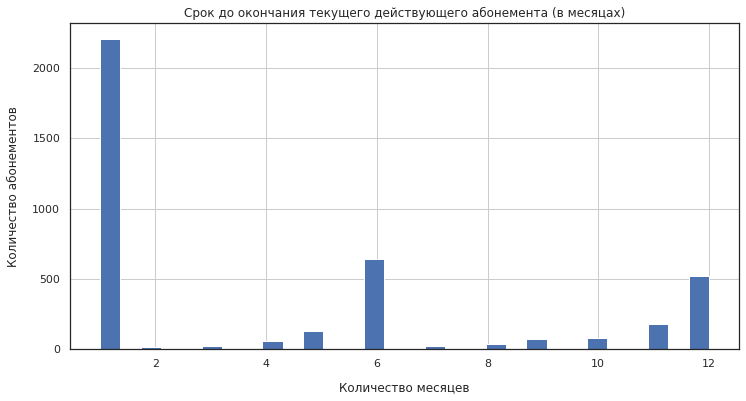

In [130]:
gym_churn['month_to_end_contract'].hist(bins=30, figsize=(12,6)).set_title (
    'Cрок до окончания текущего действующего абонемента (в месяцах)');                              
plt.xlabel('Количество месяцев', fontsize=12, labelpad=12);
plt.ylabel('Количество абонементов', fontsize=12, labelpad=12);

Мы видим, что и более длительные контракты находятся преимущественно в начале своего срока использования.

Продолжим анализ описательных статистик:

In [131]:
gym_churn['lifetime'].value_counts()

1     843
2     610
3     490
0     487
4     383
5     273
6     220
7     167
8     111
9     100
10     76
12     53
11     48
13     28
14     24
15     24
16     15
17     11
19      7
20      7
18      7
21      5
24      2
22      2
26      2
23      2
29      1
27      1
31      1
Name: lifetime, dtype: int64

- время с момента первого обращения в фитнес-центр (в месяцах): у 75% пользователей первое знакомство состоялось не более 5 месяцев назад. А максимальное "время жизни" пользователей данного центра - 31 месяц. И это один человек, видимо, директор.
- средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота за последний месяц различаются незначительно и в среднем составляют 1.88 и 1.78 раз в неделю, распределение близкое к нормальному Хотя оптимальным для здоровья показателем являются занятия через день, то есть три раза в неделю. 

**<font color="purple">Таким образом, мы можем составить следующий портрет нашего фитнес центра и контингента занимающихся: Наш фитнес центр продает абонементы длительностью 1 месяц, 6 месяцев и 12 месяцев. Активно сотрудничает с корпоративными компаниями, предоставляя дополнительные скидки для привлечения их сотрудников в качестве пользователей услуг. Половина всех занимающихся - сотрудники фирм-партнеров. Фитнес-центр также активно использует промо программы типа Приведи друга. Треть всех пользователей пришли именно по этой программе. Усилия по привлечению пользователей не проходят даром. Однако у фитнес центра есть явные проблемы. Половина всех абонементов - длительностью лишь один месяц и большая часть абонементов - новые. То есть посетители клюют на рекламу и дополнительные скидки, но в фитнес центре не задерживаются и по окончании пробного месяца уходят и сменяются новыми. Посетители центра - молодые мужчины и женщины от 18 до 41 года, работающие или живущие рядом с фитнес центром. Групповые занятия посещают не часто, дополнительных денег за другие услуги оставляют мало. Напрашивается два предположения: 1) контингент посетитетелей - с низкой платежной способностью, желающие начать здоровый образ жизни за низкую цену, но недостаточно целеустремленные, 2) фитнес центр тратит значительные усилия на привлечение, но не на удержание пользователей: может быть внутри неуютно, неудобно; персонал грубый, неприветливый; кормят не вкусно и т.д.
</font>** 

### Сравнение уходящих и остающихся клиентов <a id="comparison"></a>

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался 

In [132]:
gym_churn.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


**<font color="purple">Сравним портреты пользователей, которые ушли или остались в текущем месяце: уходящим в равной степени может быть и мужчина и женщина, средний возраст 27 лет. Остающиеся - более умудренные - средний возраст порядка 30 лет. В оттоке немного больше клиентов, кто живет и работает далеко от центра и в 1.5 меньше клиентов - сотрудников фирм-партнеров. 18% всех уходящих, пришли по промо Приведи друга: это в два раза меньше чем остающихся клиентов, которые пришли по этой же промо акции. Средний срок действия абонемента у оттока составляет 1.72. Остающиеся имеют среднию длительность абонемента ближе к 6 месяцам. Те кто остается более склонны посещать груповые занятия и тратить деньги за дополнительные услуги. Ходят в центр чаще - порядка 2 раз в неделю и в среднем за весь период действия абонемента и за последний месяц. Клиенты в оттоке начинают за здравие: в среднем количество посещений за весь период действия абонемента составляет 1.47 раза в неделю. Но за предыдущий месяц частота снижается до 1 посещения в неделю. "Срок жизни" уходящих с момента первого знакомства с центром составляет 1 месяц, в то время как остающиеся клиенты дружат с фитнес центром в среднем 5 месяцев. Отсюда задача для бизнеса: продумать стратегию удержания клиентов с первого месяца знакомства с ними, у фитнес центра есть один месяц на это, поскольку подавляющее большинство абонементов именно такой длительности.</font>** 

### Распределение признаков в группах клиентов уходящих в отток и остающихся  <a id="histogram"></a>

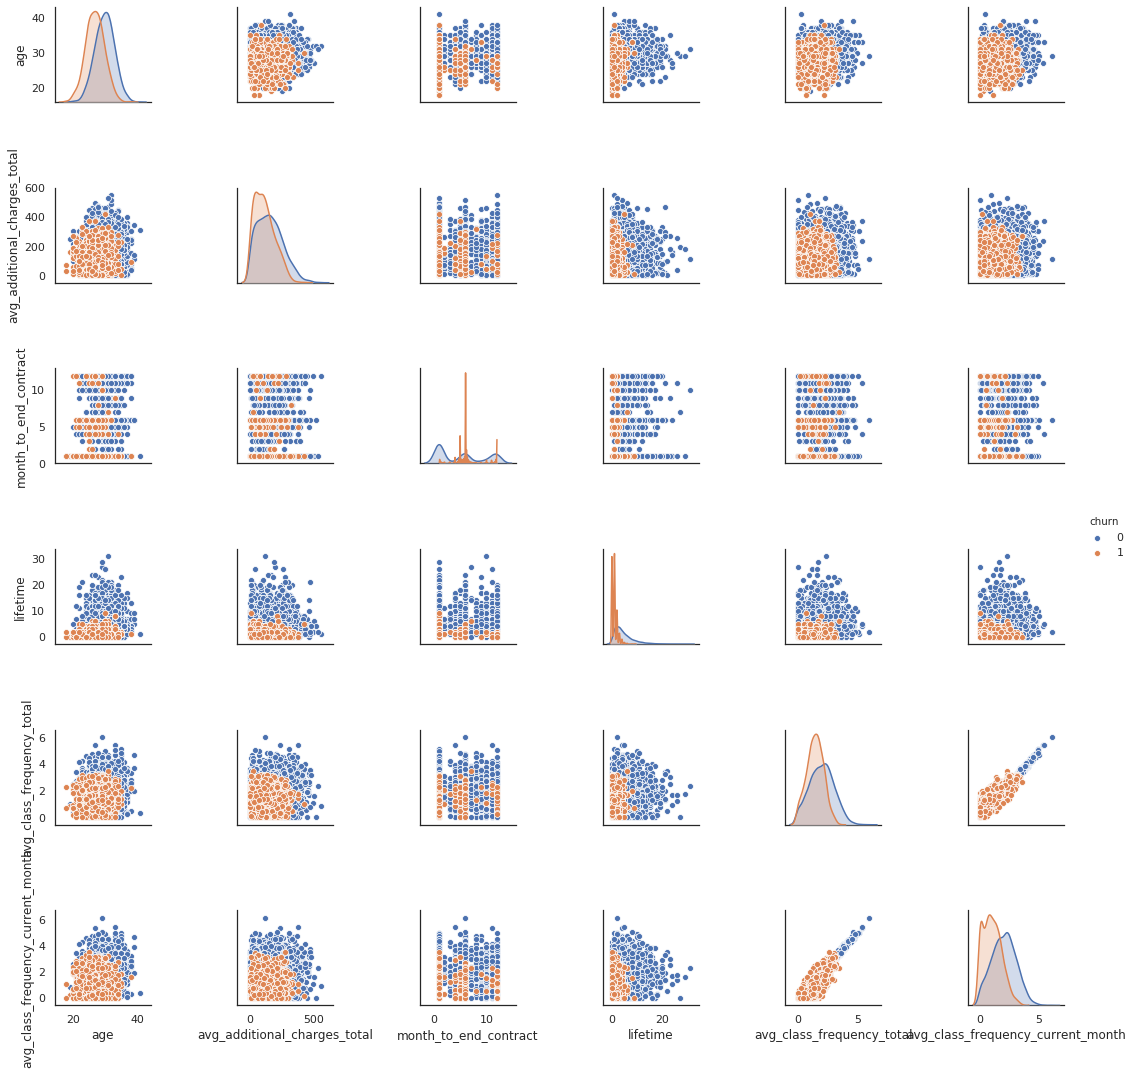

In [133]:
#Посмомтрим распределения всех числовых признаков кроме длительности контракта в группах оттока и
#в группах остающихся клиентов. А также как связаны признаки между собой в этих двух группах
sns.pairplot(gym_churn, hue="churn", vars=['age', 'avg_additional_charges_total',\
'month_to_end_contract','lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']);

Что мы видим на гистограммах распределения признаков:
1) Гистограммы распределения признаков в группе оттока размещены левее гистограмм распределения в группе остающихся клиентов. Т.е. те кто уходят это: более молодые, реже посещающие спортзал и меньше тратящие на дополнительные услуги клиенты. Сами распределения нормальные либо близкие к нормальным.
2) Попарные графики взаимосвязи числовых признаков показывают такую же тенденцию, что и в первом пункте: в диаграммах рассеяния для группы оттока точки попарных переменных стремятся к центру координат, в то время как для группы остающихся клиентов рассеяние имеет более широкий диапазон.

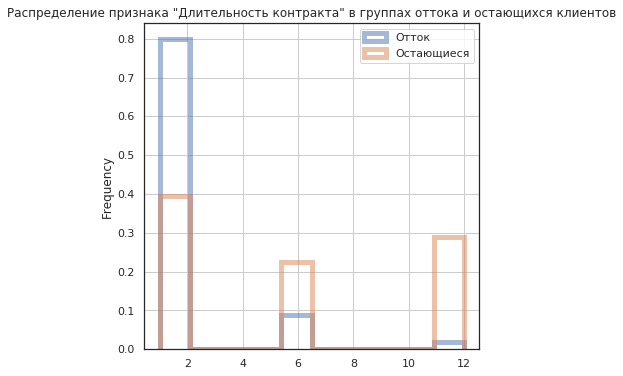

In [134]:
#Для лучшей визуализации, посмотрим распределение признака "Длительность контракта" отдельно
ax = gym_churn.query('churn==1')['contract_period'].plot(kind='hist', y='contract_period',\
histtype='step', linewidth=5, alpha=0.5, figsize=(6, 6), label='Отток', density=True, legend=True,\
        title='Распределение признака "Длительность контракта" в группах оттока и остающихся клиентов');
gym_churn.query('churn==0')['contract_period'].plot(kind='hist', y='contract_period', histtype='step',\
linewidth=5, alpha=0.5, figsize=(6, 6), label='Остающиеся',\
                                                    ax=ax, grid=True, legend=True, density=True);


На графике выше наблюдаем очевидный тренд: клиенты из оттока реже покупают абонементы длительностью более 1 месяца.

###  Матрица корреляций признаков<a id="correlation_matrix"></a>

Построим матрицу корреляций для оценки степени линейной зависимости признаков между собой:

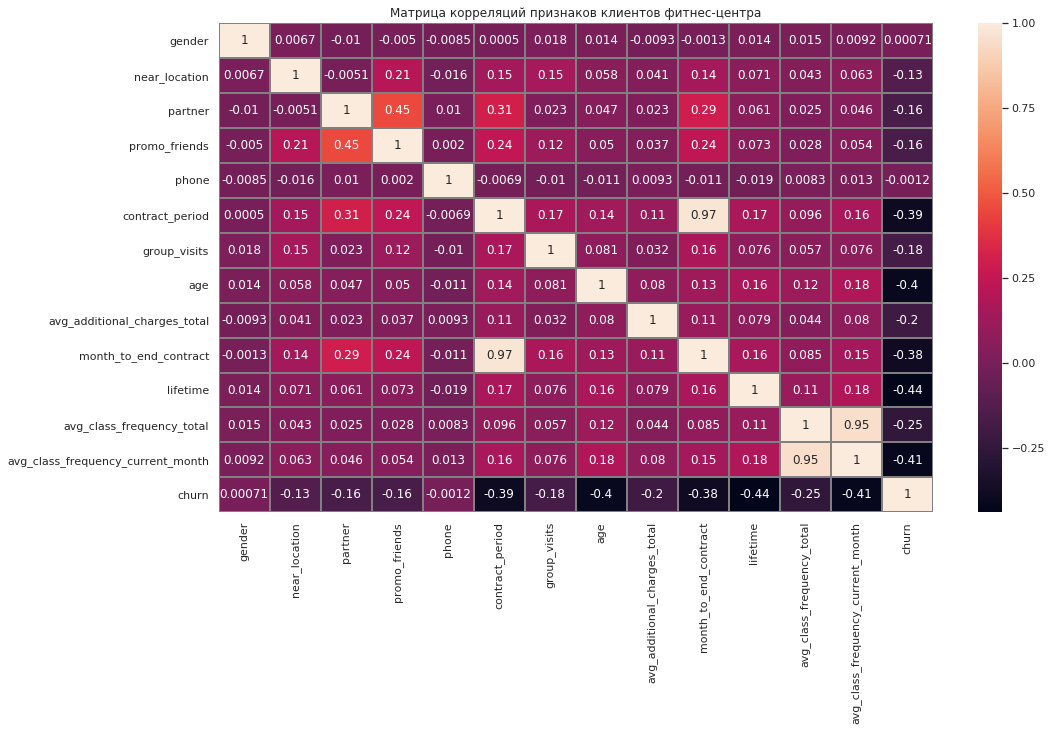

In [135]:
cm = gym_churn.corr()
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Матрица корреляций признаков клиентов фитнес-центра')
sns.heatmap(cm, annot=True, linewidths=1, linecolor='gray');

На матрице мы видим сильную корреляцию двух пар признаков: 1) частота посещения общая и частота посещения за последний месяц и 2) длительность контракта и количество месяцев до окончания контракта. Это наблюдение необходимо учесть в дальнейшем анализе.
Остальные признаки мало коррелируют друг с другом и с целевой переменной. То есть линейная зависимость между признаками слабо выражена. Равно как и зависимость между целевой переменной и всеми признаками. Характер зависимости другой. 

## 4. Модель прогнозирования оттока пользователей <a id="model"></a>

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце. Обучим модель с помощью двух алгоритмов: логистической регрессии и случайным лесом. Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. 

In [136]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('churn', axis = 1)
y = gym_churn['churn']

In [137]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [138]:
#Задаем алгоритмы для наших моделей
models = [LogisticRegression(), RandomForestClassifier(n_estimators = 100, random_state=0)]

In [139]:
#Напишем функцию, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    
    print('Accuracy:{:.2f} Precision: {:.2f} Recall: {:.2f} F1: {:.2f} ROC_AUC: {:.2f}'.format(
        accuracy_score(y_test, predictions),\
        precision_score(y_test, predictions),\
        recall_score(y_test, predictions),\
        f1_score(y_test, predictions),\
        roc_auc_score(y_test, probabilities)))
                            

In [140]:
# напишем цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(m=i,X_train = X_train, y_train= y_train,
                    X_test=X_test, y_test = y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy:0.93 Precision: 0.89 Recall: 0.84 F1: 0.87 ROC_AUC: 0.98
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy:0.92 Precision: 0.88 Recall: 0.83 F1: 0.85 ROC_AUC: 0.97


## 5. Кластеризация пользователей <a id="clastering"></a>

###  Иерархическая кластеризация <a id="dendrogram"></a>

In [141]:
#Стандартизируем данные
# создаём объект класса scaler (нормализатор)
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
# обучаем нормализатор и преобразуем набор данных 
x_sc = scaler.fit_transform(gym_churn.drop(columns = ['churn'])) 

In [142]:
#Построем матрицу расстояний функцией linkage() на стандартизованной матрице признаков 
linked = linkage(x_sc, method = 'ward') 

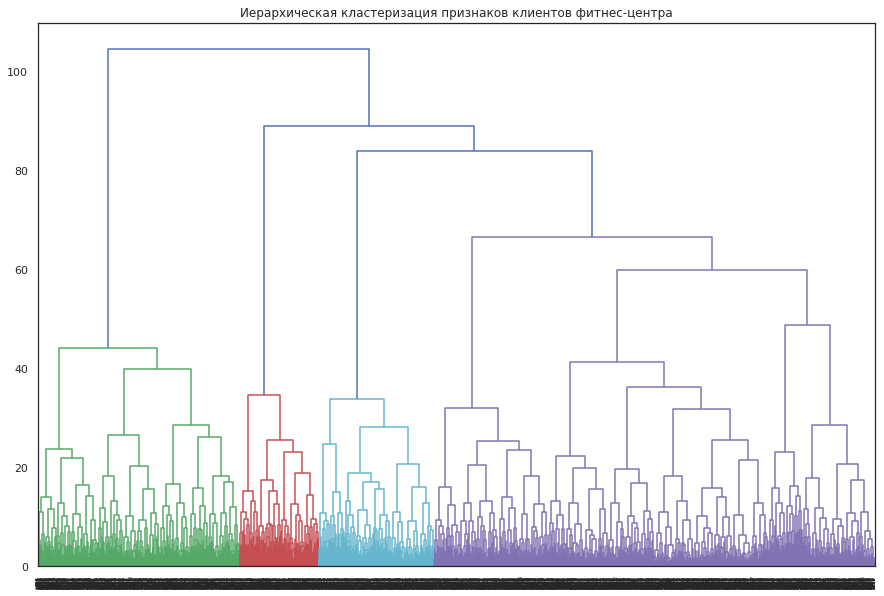

In [143]:
#нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация признаков клиентов фитнес-центра')
plt.show()

**<font color="purple">Алгоритм на основе значений признаков нашей базы предложил оптимально четыре кластера. Интересно, что более половины данных базы были причислены к одному кластеру, выделенному фиолетовым цветом. Посмотрим, как отработает алгоритм кластеризации K-means
</font>** 

###  Кластеризация на основе алгоритма K-means <a id="k-means"></a>

In [144]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters = 5, random_state=0)

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(x_sc)

In [145]:
# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
clusters = gym_churn.groupby(['cluster_km']).mean()
clusters

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


In [146]:
#Отсортируем столбец Отток по увеличению возможного риска оттока и, соответственно, уменьшению 
#надежности
clusters['churn'].sort_values()

cluster_km
0    0.027695
4    0.068100
1    0.267532
2    0.443564
3    0.514263
Name: churn, dtype: float64

In [147]:
#Посмотрим на распределение наших признаков в пределах кластеров.Разобьем нашу выборку на две:
#В первой соберем признаки с бинарными значениями, а также признак contract_period, во второй - 
#с множественными значениями
features_binary = gym_churn[['contract_period', 'gender', 'near_location', 'partner', 'promo_friends', 'phone',\
                             'group_visits', 'churn', 'cluster_km']]
features_multiple = gym_churn[['age', 'avg_additional_charges_total',\
                    'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'cluster_km']]

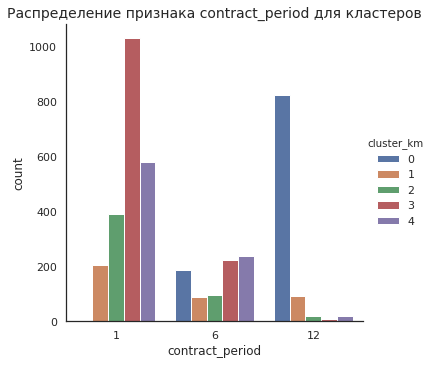

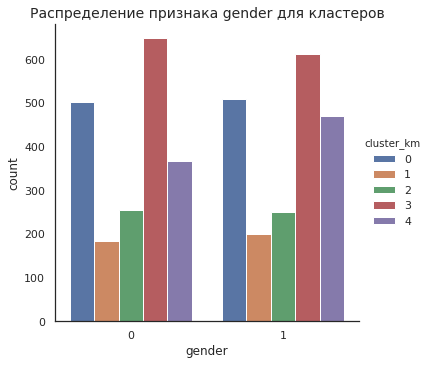

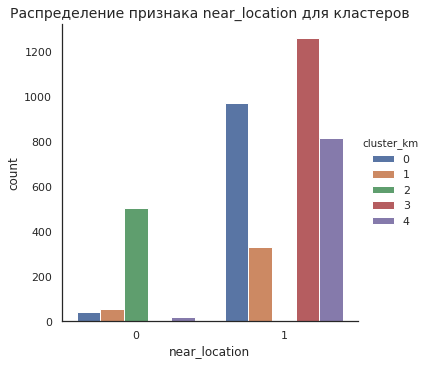

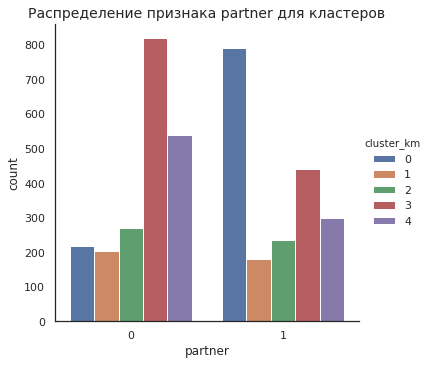

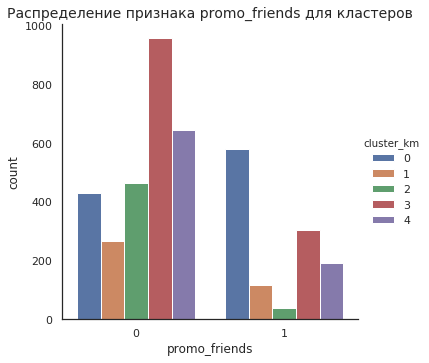

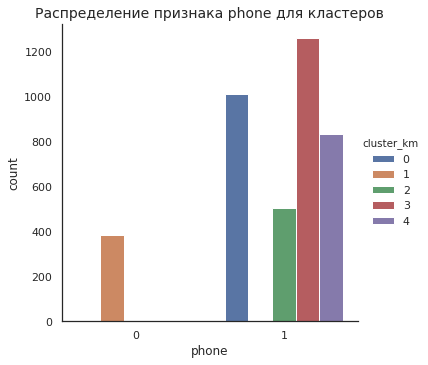

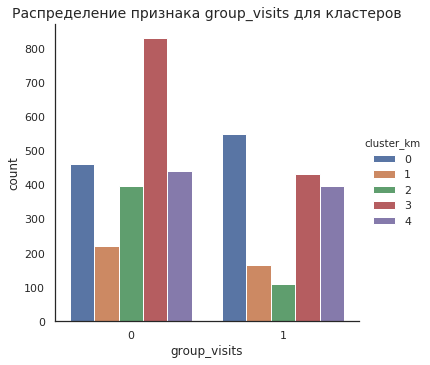

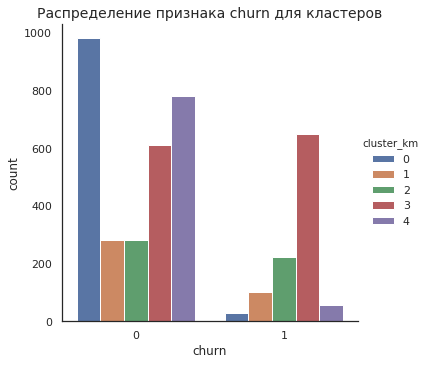

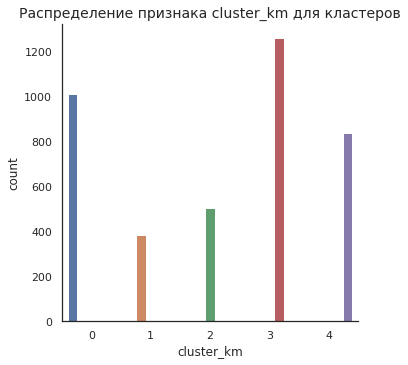

In [150]:
for col in features_binary.columns:
    sns.catplot(x=col, hue="cluster_km", kind="count", data=features_binary);
    plt.title('Распределение признака {} для кластеров'.format(col), fontsize=14);
    plt.show()


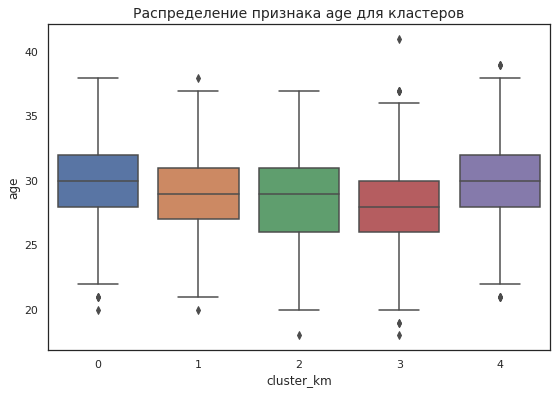

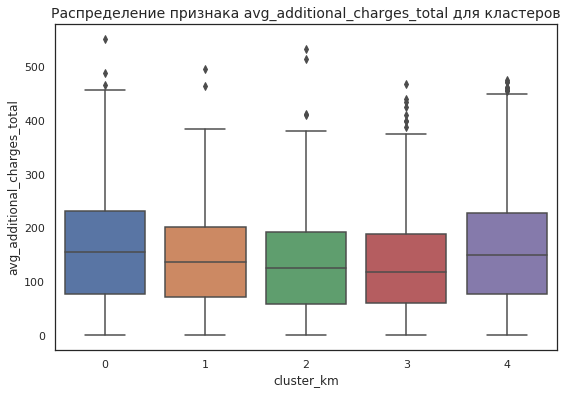

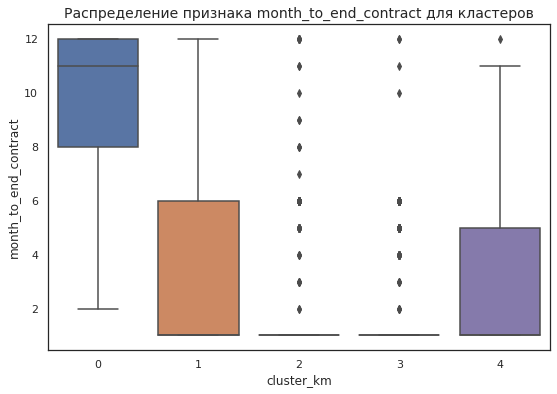

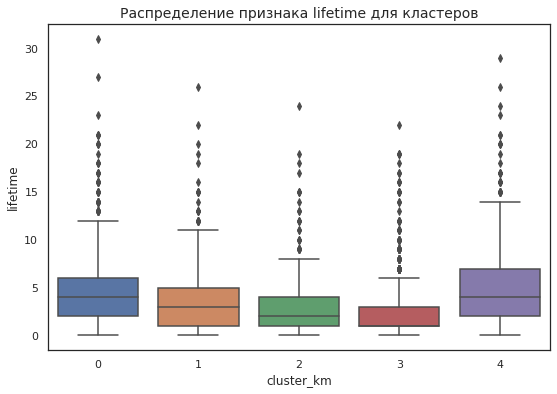

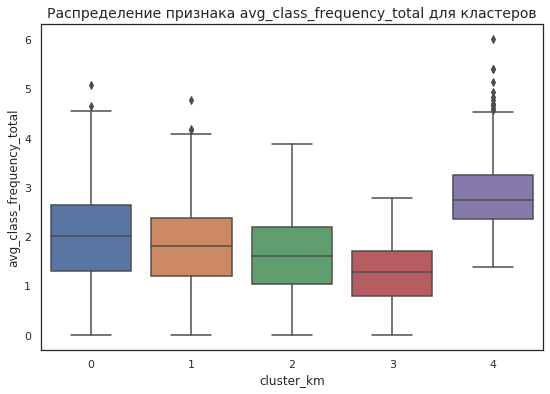

In [149]:
for col in features_multiple.drop(columns=['cluster_km']).columns:
    plt.figure(figsize=(9, 6))
    sns.boxplot(y=col, x="cluster_km", data=features_multiple)
    plt.title('Распределение признака {} для кластеров'.format(col), fontsize=14)
    plt.show()

<font color="purple"> На основе средних значений признаков по каждому кластеру и графиков распределения признаков по кластерам, можем выделить следующие особенности кластеров:
- Кластер 0: Клиенты, которые покупают самые длительные абонементы, активно посещают групповые занятия. Здесь больше всего сотрудников компаний-партнеров и проданных абонементов по промоакции Приведи друга. Самый надежный контингент клиентов
- Кластер 1: Сюда попали все анкеты клиентов, где отсутствует контактные номер телефона. Понятно, что этот факт ограничивает взаимодействие с клиентами и сужает спектр маркетинговых активностей по удержанию - 3 класс надежности, непредсказуемые клиенты, с которыми даже не связаться, чтобы узнать, куда пропали.
- Кластер 2: Клиенты проживают далеко от фитнес центра, здесь меньше всего абонементов, проданных по промопрограмме приведи друга и наименьший процент клиентов, посещающих групповые занятия. 4 класс надежности 
- Кластер 3:  Самая молодая группа (и по возрасту и по продолжительности дружбы с фитнес центром) с наименее длительным сроком действия абонемента. Реже клиентов остальных кластеров посещающие фитнес центр в принципе - наиболее вероятные кандидаты на отток. Покупают абонементы импульсивно, видимо, начиная новую жизнь с понедельника и благополучно забивающие на занятия. При этом 100% этих клиентов живут или работают рядом с фитнес центром. Ведущие кандидаты на отток.</font>
       
<font color="purple">- Кластер 4: Наиболее "возрастные", часто посещающие, больше всех тратящие на дополнительные услуги клиенты, дольше остальных кластеров дружат с нашим фитнес-центром - вторые по надежности
</font>


## 6. Выводы <a id="summary"></a>

**<font color="purple">В работе провели анализ клиентской базы фитнес центра: сформировали типичные портреты пользователей, выделили нескоколько наиболее ярких групп с основными свойствами. Проанализировали основные признаки, наиболее сильно влияющие на отток. Разработали рекомендации по повышению качества работы с клиентами.
</font>** 

**<font color="purple">Фитнес центр продает абонементы длительностью 1 месяц, 6 месяцев и 12 месяцев. Активно сотрудничает с корпоративными компаниями, предоставляя дополнительные скидки для привлечения их сотрудников в качестве пользователей услуг. Половина всех занимающихся - сотрудники фирм-партнеров. Фитнес-центр также активно использует промо программы типа Приведи друга. Треть всех пользователей пришли именно по этой программе.
</font>** 

**<font color="purple">Половина всех абонементов - длительностью лишь один месяц и большая часть абонементов - новые. То есть посетители клюют на рекламу и дополнительные скидки, но в фитнес центре не задерживаются и по окончании пробного месяца уходят и сменяются новыми. Посетители центра - молодые мужчины и женщины от 18 до 41 года, преимущественно работающие или живущие рядом с фитнес центром. 
</font>** 

**<font color="purple">Портреты пользователей, которые ушли или остались в текущем месяце: уходящим в равной степени может быть и мужчина и женщина, средний возраст 27 лет. Остающиеся - более умудренные - средний возраст порядка 30 лет. В оттоке немного больше клиентов, кто живет и работает далеко от центра и в 1.5 меньше клиентов - сотрудников фирм-партнеров. 18% всех уходящих, пришли по промо Приведи друга: это в два раза меньше чем остающихся клиентов, которые пришли по этой же промо акции. Средний срок действия абонемента у оттока составляет 1.72. Остающиеся имеют среднию длительность абонемента ближе к 6 месяцам. Те кто остается более склонны посещать груповые занятия и тратить деньги за дополнительные услуги. Ходят в центр чаще - порядка 2 раз в неделю и в среднем за весь период действия абонемента и за последний месяц. Клиенты в оттоке начинают за здравие: в среднем количество посещений за весь период действия абонемента составляет 1.47 раза в неделю. Но за предыдущий месяц частота снижается до 1 посещения в неделю. "Срок жизни" уходящих с момента первого знакомства с центром составляет 1 месяц, в то время как остающиеся клиенты дружат с фитнес центром в среднем 5 месяцев. Отсюда задача для бизнеса: продумать стратегию удержания клиентов с первого месяца знакомства с ними, у фитнес центра есть один месяц на это, поскольку подавляющее большинство абонементов именно такой длительности.</font>** 

**<font color="purple">Анализ степени корреляции признаков между собой показал, что линейная зависимость между признаками слабо выражена за исключением пар признаков:1) частота посещения общая и частота посещения за последний месяц и 2) длительность контракта и количество месяцев до окончания контракта. Линейная зависимость между целевой переменной и каждым признаком также выражена слабо. Характер зависимости другой.</font>** 

**<font color="purple">Алгоритм прогнозирования методом логистической регрессии показал себя немного лучше при обучении и тестировании модели. Однако разница незначительная и мы можем с одинаковым успехом использовать обе модели.
</font>** 

**<font color="purple">С помощью иерархической кластеризации сформировано 4 кластера признаков. С помощью алгоритма кластеризации K-means было сформировано 5 кластеров - портртеров клиентов. Самые надежные - клиенты, которые покупают длительные абонементы (крупные траты обязывают отрабатывать). Эти клиенты активно посещают групповые занятия. Здесь больше всего сотрудников компаний-партнеров и проданных абонементов по промоакции Приведи друга.</font>**   
    
**<font color="purple">Основные кандидаты на отток - молодежь, проживающая или работающая рядом с фитнес-центром. Покупают в основном краткосрочные абонементы и редко посещающие фитнес центр в принципе. Вероятно, покупают абонементы импульсивно, возможно перед началом пляжного сезона или начиная жизнь с понедельника, но быстро теряют мотивацию и ходят в зал от случая к случаю. Для таких клиентов важно поддержать мотивацию посредством электронных рассылок, постеров и экранов внутри фитнес центра с мотивационным контентом. 
</font>** 

**<font color="purple">Вторая группа риска - клиенты, живущие не близко. Они уходят скорей всего потому, что просто устают добираться. Ездят только в бассейн или качалку, групповые занятия не посещают. Привлечь их можно, по нашему мнению лишь конкурентной ценой.
</font>** 